In [1]:
import numpy as np
import cirq
import mitiq
import mitiq.pec
import mitiq.benchmarks
import matplotlib.pyplot as plt

**Probabilistic Error Cancelation**

Probabilistic error cancellation (PEC) is an error mitigation technique in which ideal operations are represented as linear combinations of noisy operations. In PEC, unbiased estimates of expectation values are obtained by Monte Carlo averaging over different noisy circuits (see [What is the theory behind PEC?](https://mitiq.readthedocs.io/en/stable/guide/pec-5-theory.html) for more information on the theory).

#### Demo circuit -- single-qubit RB circuit

In [2]:
# single-qubit randomized benchmarking circuit

circ = mitiq.benchmarks.generate_rb_circuits(
    1, num_cliffords=2
)[0]
circ

0: ───X^-0.5───Y^0.5───Y^-0.5───X^0───X^0.5───Y^0───

In [3]:
circ.all_qubits()

frozenset({cirq.LineQubit(0)})

In [4]:
def execute(circ: cirq.Circuit, noise_level=0.01):
    circ = mitiq.interface.convert_to_mitiq(circ)[0]
    circ_noisy = circ.with_noise(cirq.depolarize(noise_level))
    rho = cirq.DensityMatrixSimulator().simulate(circ_noisy).final_density_matrix
    return rho[0,0].real

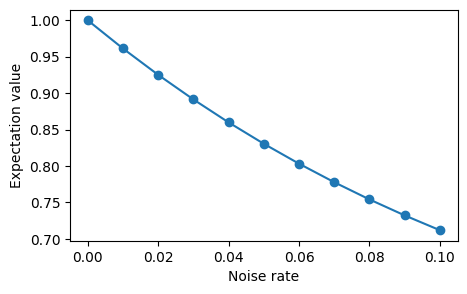

In [5]:
rates = np.linspace(0, 0.1, 11)
vals = [execute(circ, rate) for rate in rates]

plt.figure(figsize=(5,3))
plt.plot(rates, vals, 'o-')
plt.xlabel('Noise rate')
plt.ylabel('Expectation value')
plt.show()

In [6]:
# represent "idea gates" as linear combinations of "noisy gates"

reps = mitiq.pec.represent_operations_in_circuit_with_local_depolarizing_noise(circ, noise_level=0.01)
type(reps[0]), len(reps)

(mitiq.pec.types.types.OperationRepresentation, 6)

In [7]:
print(reps[0])
print(reps[1])
print(reps[2])
print(reps[3])

0: ───X^0─── = 1.010*(0: ───X^0───)-0.003*(0: ───X^0───X───)-0.003*(0: ───X^0───Y───)-0.003*(0: ───X^0───Z───)
0: ───X^0.5─── = 1.010*(0: ───X^0.5───)-0.003*(0: ───X^0.5───X───)-0.003*(0: ───X^0.5───Y───)-0.003*(0: ───X^0.5───Z───)
0: ───Y^0─── = 1.010*(0: ───Y^0───)-0.003*(0: ───Y^0───X───)-0.003*(0: ───Y^0───Y───)-0.003*(0: ───Y^0───Z───)
0: ───X^-0.5─── = 1.010*(0: ───X^-0.5───)-0.003*(0: ───X^-0.5───X───)-0.003*(0: ───X^-0.5───Y───)-0.003*(0: ───X^-0.5───Z───)


In [8]:
reps[0].coeffs

[1.010135135135135,
 -0.003378378378378378,
 -0.003378378378378378,
 -0.003378378378378378]

In [9]:
np.array(reps[0].coeffs) / np.abs(reps[0].coeffs).sum()

array([ 0.99006623, -0.00331126, -0.00331126, -0.00331126])

In [10]:
val_noisy = execute(circ, noise_level=0.01)
val_pec = mitiq.pec.execute_with_pec(circ, execute, representations=reps)

In [11]:
val_pec, val_noisy

(1.0001993417750643, 0.9613098)

In [12]:
def cal_coeffs(noise_level):
    eta1 = 1 + 3/4 * noise_level / (1 - noise_level)
    eta2 = (1 - eta1) / 3
    return eta1, eta2, eta2, eta2

In [13]:
cal_coeffs(0.01)

(1.0075757575757576,
 -0.002525252525252523,
 -0.002525252525252523,
 -0.002525252525252523)

#### Practical circuit -- 8-qubit random circuit

In [14]:
from cirq.contrib.qasm_import import circuit_from_qasm

In [15]:
with open('../benchmarks/random/rand_8.qasm') as f:
    qasm = f.read()
circ = circuit_from_qasm(qasm)
circ = circ[:10]

In [16]:
circ

┌──────┐   ┌─────┐          ┌─────┐   ┌──────┐   ┌─────┐   ┌─────────┐   ┌──┐
q_0: ─────────X─────T────────T───────S─────────@──────────S─────────S─────────────T─────S───T^-1───
              │                                │
q_1: ────S────┼─────────@────T^-1────T─────────┼────@─────T─────────────X──────────X────T───T^-1───
              │         │                      │    │                   │          │
q_2: ────T^-1─┼─────S^-1┼────H───────────@─────┼S^-1┼─────T^-1──────T^-1┼─────────X┼────H───H──────
              │         │                │     │    │                   │         ││
q_3: ────────@┼─────S───┼────S^-1────X───┼─────┼H───┼─────────X─────T───┼─────────@┼────@───T──────
             ││         │            │   │     │    │         │         │          │    │
q_4: ────H───┼┼─────S───┼────X───────┼───X─────X────┼─────S───┼─────X───┼──────────@────X───@──────
             ││         │            │              │         │     │   │                   │
q_5: ────S───┼┼─────X───┼────S───────@─────────X────┼─────S^-1┼─────┼───┼S^-1─────S─────S───X──────
             ││     │   │                      │    │         │     │   │
q_6: ────────┼@─────┼───X────S───────T^-1──────@────┼─────H───┼─────┼───@─────────@─────X───T^-1───
             │      │                               │         │     │             │     │
q_7: ────────X──────@────────H───────T^-1───────────X─────────@─────@─────────────X─────@───H──────
        └──────┘   └─────┘          └─────┘   └──────┘   └─────┘   └─────────┘   └──┘

In [17]:
reps = mitiq.pec.represent_operations_in_circuit_with_local_depolarizing_noise(circ, noise_level=0.01)

In [23]:
q0, q1, q2 = cirq.LineQubit.range(3)
circuit = cirq.Circuit(
    cirq.H(q0),  # initialize X basis
    cirq.H(q1),  # initialize Y basis
    cirq.S(q1),
    cirq.depolarize(p=0.2).on_each(q0, q1, q2),
    cirq.H(q0),  # return to Z-basis
    cirq.S(q1) ** -1,
    cirq.H(q1),
    cirq.depolarize(p=0.2, n_qubits=2).on(q0, q1),
    cirq.measure(q0, key='result_0'),
    cirq.measure(q1, key='result_1'),
    cirq.measure(q2, key='result_2'),
)
result = cirq.Simulator(seed=0).run(circuit, repetitions=1000)
# All basis states are equally affected.
print("X basis:", result.histogram(key='result_0'))
print("Y basis:", result.histogram(key='result_1'))
print("Z basis:", result.histogram(key='result_2'))

X basis: Counter({0: 791, 1: 209})
Y basis: Counter({0: 772, 1: 228})
Z basis: Counter({0: 860, 1: 140})


In [24]:
circuit

0: ───H────────D(0.2)──────────H───────────────────D(0.2)───M('result_0')───
                                                   │
1: ───H────────S───────────────D(0.2)───S^-1───H───#2───────M('result_1')───

2: ───D(0.2)───M('result_2')────────────────────────────────────────────────

In [ ]:
cirq.depolarize

In [ ]:
cirq.depolarize

In [227]:
len(reps)

41

In [228]:
print(len(reps[0].coeffs))
print(reps[0])

4
q_0: ───S─── = 1.010*(q_0: ───S───)-0.003*(q_0: ───S───X───)-0.003*(q_0: ───S───Y───)-0.003*(q_0: ───S───Z───)


In [229]:
reps[-1].ideal, reps[-1].coeffs

(q_6: ───X───
        │
q_7: ───@───,
 [1.0203729912344777,
  -0.003412618699780862,
  -0.003412618699780862,
  -0.003412618699780862,
  -0.003412618699780862,
  -0.003412618699780862,
  -0.003412618699780862,
  1.1413440467494523e-05,
  1.1413440467494523e-05,
  1.1413440467494523e-05,
  1.1413440467494523e-05,
  1.1413440467494523e-05,
  1.1413440467494523e-05,
  1.1413440467494523e-05,
  1.1413440467494523e-05,
  1.1413440467494523e-05])

In [230]:
type(reps[0])

mitiq.pec.types.types.OperationRepresentation

In [231]:
len(list(circ.all_operations()))

62

In [232]:
type(list(circ.all_operations())[0])

cirq.ops.gate_operation.GateOperation

In [233]:
reps[0].sample()

(<mitiq.pec.types.types.NoisyOperation at 0x7fb613c618e0>,
 1,
 1.010135135135135)

In [234]:
reps[-1].ideal

q_6: ───X───
        │
q_7: ───@───

In [238]:
val_ideal = execute(circ, noise_level=0)
val_noisy = execute(circ, noise_level=0.005)

In [239]:
val_ideal, val_noisy

(0.015624997, 0.0143068945)

#### Construct `NoisyOperation` manually

In [181]:
import qiskit

basis_circuit_h = qiskit.QuantumCircuit(1)
basis_circuit_h.h(0)

basis_circuit_hx = qiskit.QuantumCircuit(1)
basis_circuit_hx.h(0)
basis_circuit_hx.x(0)

basis_circuit_hy = qiskit.QuantumCircuit(1)
basis_circuit_hy.h(0)
basis_circuit_hy.y(0)

basis_circuit_hz = qiskit.QuantumCircuit(1)
basis_circuit_hz.h(0)
basis_circuit_hz.z(0)

basis_circuits = [basis_circuit_h, basis_circuit_hx, basis_circuit_hy, basis_circuit_hz] 

for c in basis_circuits:
    print(c)
    
from mitiq.pec.representations import local_depolarizing_kraus
from mitiq.pec.channels import kraus_to_super

# Compute depolarizing superoperator
BASE_NOISE = 0.01
depo_super = kraus_to_super(local_depolarizing_kraus(BASE_NOISE, num_qubits=1))

# Define the superoperator matrix of each noisy operation
super_matrices = [
    depo_super @ kraus_to_super([qiskit.quantum_info.Operator(c).data]) 
    for c in basis_circuits
]

# Define NoisyOperation objects combining circuits with channel matrices
noisy_operations = [
    mitiq.pec.NoisyOperation(circuit=c, channel_matrix=m)
    for c, m in zip(basis_circuits, super_matrices)
]

print(f"{len(noisy_operations)} NoisyOperation objects defined.")

   ┌───┐
q: ┤ H ├
   └───┘
   ┌───┐┌───┐
q: ┤ H ├┤ X ├
   └───┘└───┘
   ┌───┐┌───┐
q: ┤ H ├┤ Y ├
   └───┘└───┘
   ┌───┐┌───┐
q: ┤ H ├┤ Z ├
   └───┘└───┘
4 NoisyOperation objects defined.


In [184]:
reps = mitiq.pec.representations.find_optimal_representation(basis_circuit_h, noisy_operations)
reps.coeffs

[1.0101351149324356,
 -0.00337837831080956,
 -0.003378378310809782,
 -0.003378378310809116]

In [182]:
basis_circuit_h

<function cirq.qis.channels.kraus_to_superoperator(kraus_operators: Sequence[numpy.ndarray]) -> numpy.ndarray>